loaded 1 existing images from dataset
loaded 1 existing weights from weights-minTrue-r20


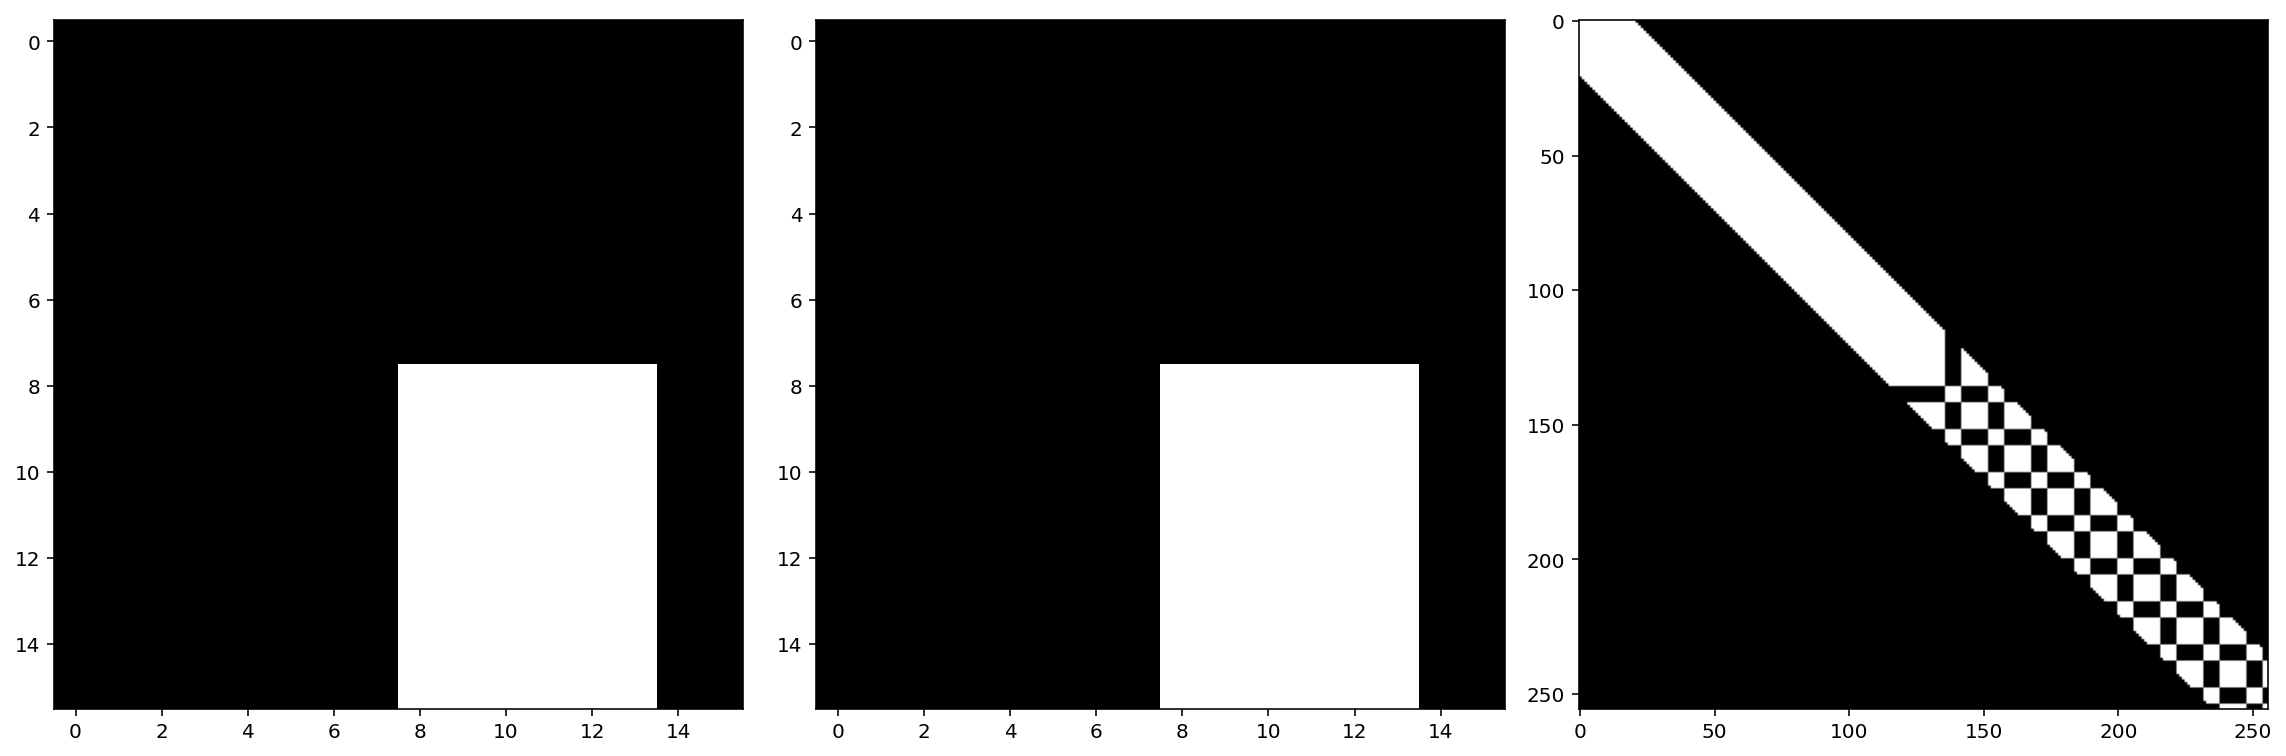

In [59]:
# THE DATA PORTION
# load a sample, see how it looks

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from net_argparser import net_argparser
from data import *

args = net_argparser(ipynb=True)
args.network = 1
args.total_images = 1
args.minify = True
args.radius = 20
args.img_size = [16,16] # the default is 32,32 anyway

train_dataset = SimpleDatasets(args, transform=transforms.ToTensor())
row = [train_dataset.get_image(0), train_dataset.get_segmentation(0), de_minW(train_dataset.get_weights(0))]

plot_multiple_images(0, row, figsize=args.img_size, ipynb=True)

torch.Size([256, 256])
D,x torch.Size([256, 256]), torch.Size([256, 256])


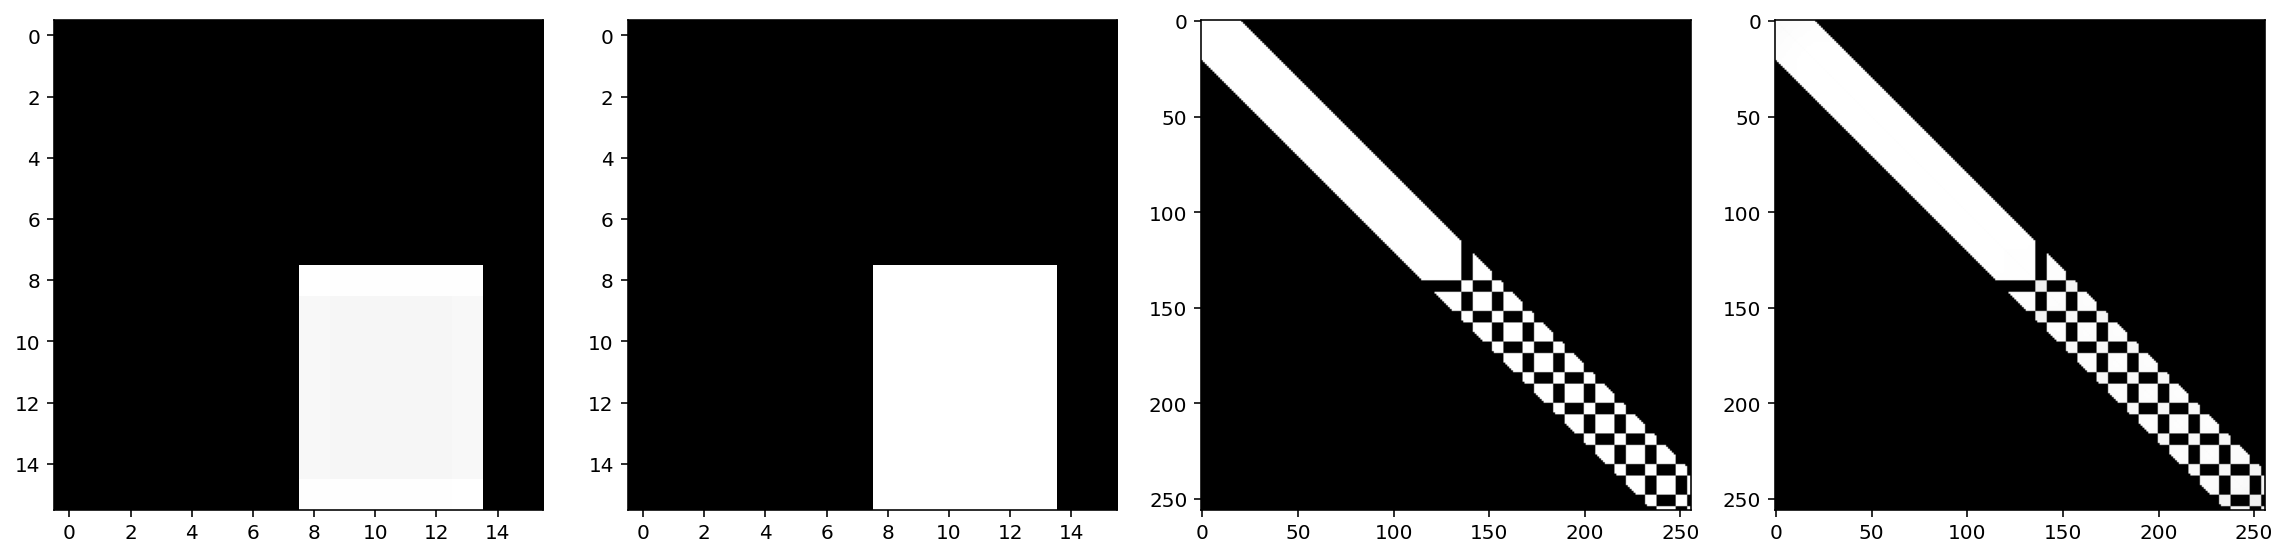

In [60]:
# try it without using the existing NC node
# TODO: fix

import torch

def distance_matrix(mat):
    d= ((mat.unsqueeze (0)-mat.unsqueeze (1))**2).sum(2)**0.5
    return d

# from https://github.com/dimkastan/PyTorch-Spectral-clustering/blob/master/FiedlerVectorLaplacian.py
# x is the adjacency matrix
x = row[2]
x = x.squeeze()
print(x.shape)

input = row[0]
test_d = distance_matrix(input)

D = x.sum(0).diag() # degree matrix
L = D - x.float() # laplacian
print(f'D,x {D.shape}, {x.shape}')
Lsym=torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D),-0.5)),L),torch.diag(torch.pow(torch.diag(D),-0.5))) # symmetric laplacian

[u,s,v]=torch.svd(Lsym)

y = u[:,-2]
y = y.view(1,1, args.img_size[0], args.img_size[1]) 

x = x[None,None,:,:]
Lsym = Lsym[None,None,:,:]


plot_images = [y, row[1], x, Lsym]
plot_multiple_images(0, plot_images, figsize=args.img_size, ipynb=True)

In [80]:
# test slowly verifying the einsums

A = train_dataset.get_weights(0)
A_smol = train_dataset.get_weights(0).squeeze()
print(f'pre A {A.shape}, {A_smol.shape}')
A = de_minW(train_dataset.get_weights(0))
A_smol = de_minW(train_dataset.get_weights(0)).squeeze()
print(f'A {A.shape}, {A_smol.shape}')
assert torch.allclose(A.squeeze(), A_smol)

d = torch.einsum('bcij->bcj', A)
d_smol = A_smol.sum(0)
print(f'd {d.shape}, {d_smol.shape}')
assert torch.allclose(d.squeeze(), d_smol), "degree matrix error"

D = torch.diag_embed(d)
D_smol = torch.diag(d_smol)
print(f'D {D.shape}, {D_smol.shape}')
assert torch.allclose(D.squeeze(), D_smol), "diagonalising error"

D_inv_sqrt = torch.diag_embed(d).pow(-0.5) # was previously in the diag_embed, avoided inf values, but made it so they were different
D_inv_sqrt_2 = torch.diag_embed(d.pow(-0.5)) # NOTE: this is the same as using torch.mm(torch.diag(...)) with the reverse of these...
D_smol_inv_sqrt = torch.pow(torch.diag(d_smol),-0.5)
print(f'inv sqrt {D_inv_sqrt.shape}, {D_smol_inv_sqrt.shape}')
assert torch.allclose(D_inv_sqrt.squeeze(), D_smol_inv_sqrt) ,"inverse sqrt error"

L = D-A
L_smol = D_smol - A_smol
print(f'L {L.shape}, {L_smol.shape}')
# NOTE: requires matching sizes for D and A (so not minified A)
assert torch.allclose(L.squeeze(), L_smol) ,"laplacian error"

Lsym_smol = torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D_smol),-0.5)),L_smol),torch.diag(torch.pow(torch.diag(D_smol),-0.5)))
# Lsym_smol_2 = torch.mm(torch.mm(torch.diag(D_smol_inv_sqrt),L_smol),torch.diag(D_smol_inv_sqrt))
# assert torch.allclose(Lsym_smol, Lsym_smol_2) ,"smols different forms"
# RuntimeError: self must be a matrix
Lsym = torch.einsum('bcij,bcjk->bcik', torch.einsum('bcij,bcjk->bcik', D_inv_sqrt_2 , L) , D_inv_sqrt_2)
print(f'L {Lsym.shape}, {Lsym_smol.shape}')
assert torch.allclose(Lsym.squeeze(), Lsym_smol) ,"Lsym error"

pre A torch.Size([1, 1, 20, 256]), torch.Size([20, 256])
A torch.Size([1, 1, 256, 256]), torch.Size([256, 256])
d torch.Size([1, 1, 256]), torch.Size([256])
D torch.Size([1, 1, 256, 256]), torch.Size([256, 256])
inv sqrt torch.Size([1, 1, 256, 256]), torch.Size([256, 256])
L torch.Size([1, 1, 256, 256]), torch.Size([256, 256])
L torch.Size([1, 1, 256, 256]), torch.Size([256, 256])


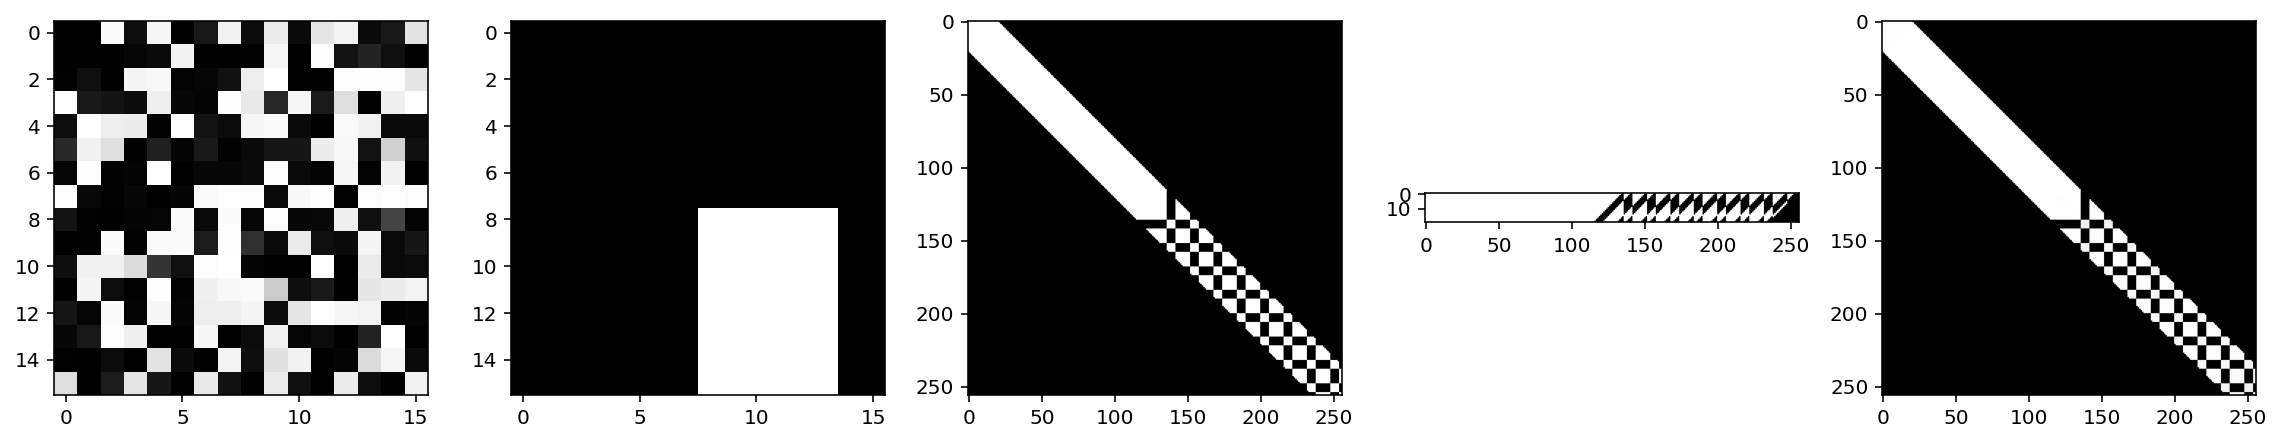

In [62]:
# test fixing the nc solve, by duplicating and making iterative changes

in_A = train_dataset.get_weights(0)
expected_y = train_dataset.get_segmentation(0)

# obtain the batch and image size (sqrt of x/y to get out_size?)
A = de_minW(in_A) # check if needs to be converted from minVer style
b,c,x,y = A.shape
out_size = int(np.sqrt(x)) # NOTE: assumes it is square..

# can also replace bc with ...
d = torch.einsum('bcij->bcj', A) # eqv to A.sum(0) --- d vector
D = torch.diag_embed(d) # D = matrix with d on diagonal
D_inv_sqrt = torch.diag_embed(d.pow(-0.5)) # Don't calculate inverse sqrt of 0 entries (non diagonals)

L = (D-A) # Laplacian matrix
# The symmetrically normalized laplacian can be calculated as D^-0.5 * L * D^-0.5 or eqv. I - D^-0.5 * A * D^-0.5 

# torch.mm(
#     torch.mm(
#         torch.diag(
#             torch.pow(
#                 torch.diag(D),-0.5)),
#         L),
#     torch.diag(
#         torch.pow(torch.diag(D),-0.5)
#         )
#     )

# ((D.diag()^-.5) * L) * ((D.diag()^-.5))

L_norm = torch.einsum('bcij,bcjk->bcik', torch.einsum('bcij,bcjk->bcik', D_inv_sqrt , L) , D_inv_sqrt)
L_norm = L_norm.to(A.device) # TODO : more elegant fix?

# Solve eigenvectors and eigenvalues
v,s,w = torch.linalg.svd(L_norm)

# Returns the second smallest eigenvector (and possibly more if num_eigs > 1)
# eigenvector(s) reshaped to match original image size
num_eigs = 1
# TODO: verify if the eig is the correct one... (narrowed to index 1 not index 0, but possible it already removes this one)

# Detach inputs from graph, attach only the output (or if using optimisation to solve you can with torch.enable_grad() ( ... optim ))
output = v.narrow(-2, 1, num_eigs).squeeze(1).reshape(b, num_eigs, out_size, out_size).requires_grad_(True)


test_plots = [output, expected_y, A, in_A, L_norm]
plot_multiple_images(0, test_plots, figsize=args.img_size, ipynb=True)

In [63]:
# # The nc.py portion
# # using the loaded data, see how it is segmented
# # TODO: fix!

# from nc import NormalizedCuts
# from node import DeclarativeLayer

# nc = NormalizedCuts(eps=1) # check if eps value is correct, also test gamma for gradients..
# decl = DeclarativeLayer(nc)

# x = row[2] # gets the full rank matrix
# y = decl(x) # as in model.py
# y = y.view(y.size(0), 1, args.img_size[0], args.img_size[1]) # convert from NC node into this

# plot_images = [y, row[1], x] # x,y, expected y (the 2nd index must always be the weights (expects one less dim))
# print(f'output:{y.shape}, expected:{row[1].shape}, weights:{x.shape}')


# plot_multiple_images(0, plot_images, figsize=args.img_size, ipynb=True)